## **Part 2 - Product Category Clustering**
-  Objective: Simplify the dataset by clustering product categories into 4-6 meta-categories.

#### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from collections import Counter
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from rapidfuzz import process
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score



#### Load the Dataset

In [ ]:
# Load dataset
df = pd.read_csv(r".\Dataset\cleaned_reviews_with_sentiment.csv")

# Keep only the relevant columns
df = df[['name', 'categories', 'reviews.rating', 'reviews', 'sentiment']]

# Rename 'reviews' to 'review' for consistency
df = df.rename(columns={'reviews': 'review'})

# Drop rows with missing product names or reviews (optional but useful)
df.dropna(subset=['name', 'review'], inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

# Preview
df.head()


,name,categories,reviews.rating,review,sentiment
0,All-New Kindle Oasis E-reader - 7 High-Resolut...,"Featured Brands,E-Readers & Accessories,EBook ...",5.0,Great device for reading. Definately pricey.. ...,Positive
1,All-New Kindle Oasis E-reader - 7 High-Resolut...,"Featured Brands,E-Readers & Accessories,EBook ...",5.0,"Excellent Kindle. The best Kindle ever, for me...",Positive
2,All-New Kindle Oasis E-reader - 7 High-Resolut...,"Featured Brands,E-Readers & Accessories,EBook ...",4.0,Love it. I absolutely love this reader. The bi...,Positive
3,All-New Kindle Oasis E-reader - 7 High-Resolut...,"Featured Brands,E-Readers & Accessories,EBook ...",5.0,Good kindle. I always use it when i read ebook...,Positive
4,All-New Kindle Oasis E-reader - 7 High-Resolut...,"EBook Readers,Tablets,Electronics,Amazon Eread...",4.0,"So much to love, but slippery. Love bigger scr...",Positive


#### TEXT ENRICHMENT

 We are going to create a new column called 'enriched_text', this will be a smarter version of the product name. It will include:
 - The product name itself
 - Its categories (as text)
 - Some keywords we add manually to help the model understand the type of product

In [17]:
# First, define a function that will take one row of the dataset and return an enriched version of the text
def enrich_text(row):
    
    enriched = row['name']
    
    # Add the categories (some products have multiple categories, separated by commas)
    if pd.notnull(row['categories']):
        enriched += ' ' + row['categories'].lower()
    
    # Now add custom keywords if we detect certain words in the name or categories
    text_to_check = enriched.lower()
    
    # If it's a tablet, add the word "tablet"
    if any(keyword in text_to_check for keyword in ['tablet', 'fire hd']):
        enriched += ' tablet'
        
    # If it's an e-reader (like a Kindle), add the word "ereader"
    if any(keyword in text_to_check for keyword in ['ebook', 'kindle', 'ereader']):
        enriched += ' ereader'
    
    # If it's a battery-related product, add the word "battery"
    if any(keyword in text_to_check for keyword in ['aaa', 'aa', 'batterie']):
        enriched += ' battery'
        
    return enriched

# Apply that function to each row in the DataFrame to create the new 'enriched_text' column
df['enriched_text'] = df.apply(enrich_text, axis=1)

# Preview a few results to see what the enriched text looks like
df[['name', 'categories', 'enriched_text']].head()

,name,categories,enriched_text
0,All-New Kindle Oasis E-reader - 7 High-Resolut...,"Featured Brands,E-Readers & Accessories,EBook ...",All-New Kindle Oasis E-reader - 7 High-Resolut...
1,All-New Kindle Oasis E-reader - 7 High-Resolut...,"Featured Brands,E-Readers & Accessories,EBook ...",All-New Kindle Oasis E-reader - 7 High-Resolut...
2,All-New Kindle Oasis E-reader - 7 High-Resolut...,"Featured Brands,E-Readers & Accessories,EBook ...",All-New Kindle Oasis E-reader - 7 High-Resolut...
3,All-New Kindle Oasis E-reader - 7 High-Resolut...,"Featured Brands,E-Readers & Accessories,EBook ...",All-New Kindle Oasis E-reader - 7 High-Resolut...
4,All-New Kindle Oasis E-reader - 7 High-Resolut...,"EBook Readers,Tablets,Electronics,Amazon Eread...",All-New Kindle Oasis E-reader - 7 High-Resolut...


Deduplicate by Product Name
If the same product appears multiple times (with different reviews), keep only one row per product.


In [18]:
df_unique = df.drop_duplicates(subset='name').copy()
df_unique['enriched_text'] = df_unique.apply(enrich_text, axis=1)
print("Unique products:", len(df_unique))


Unique products: 125


Since we are clustering textual data (product categories), we should use a pre-trained model that understands language and semantic relationships. So for this ocassion I have choosed  **BERT-Based Sentence Embeddings** (sentence-transformers/all-MiniLM-L6-v2) that apply K-Means for grouping.

In [19]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Use df_unique here, not df
embeddings = model.encode(df_unique['enriched_text'].tolist(), show_progress_bar=True)

# Convert to numpy array and print shape
embeddings = np.array(embeddings)
print("Embeddings shape:", embeddings.shape)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Embeddings shape: (125, 384)


Determine the Optimal Number of Clusters.
We use:
-  Elbow Method: Uses the inertia (sum of squared distances) to find the best number of clusters
- Silhouette Score Analysis: Measures cluster cohesion and separation.

Clustering with k = 2...
Clustering with k = 3...
Clustering with k = 4...
Clustering with k = 5...
Clustering with k = 6...
Clustering with k = 7...
Clustering with k = 8...


c:\Users\alvar\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\alvar\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\alvar\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\alvar\AppData\Local\Programs\Python\Python313\Lib\subprocess.py

Clustering with k = 9...
Clustering with k = 10...


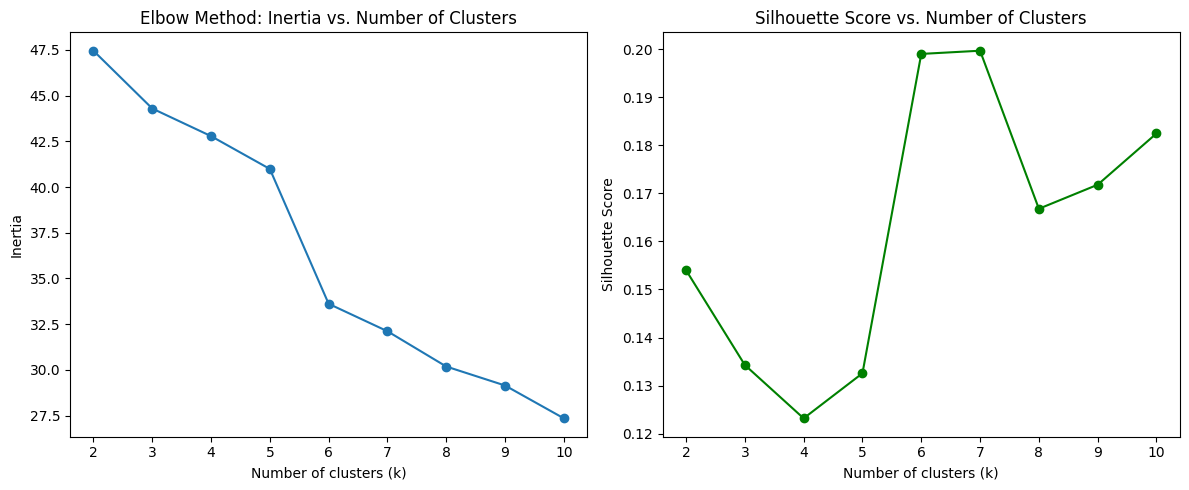

In [20]:
# Range of cluster numbers we want to test
k_range = range(2, 11)

# Store results here
inertias = []
silhouette_scores = []

# Loop through each k value (number of clusters)
for k in k_range:
    print(f"Clustering with k = {k}...")
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    
    # Save the inertia (how compact the clusters are)
    inertias.append(kmeans.inertia_)
    
    # Save the silhouette score (how well-separated the clusters are)
    score = silhouette_score(embeddings, labels)
    silhouette_scores.append(score)

# Plot the Elbow Curve and Silhouette Scores side by side
plt.figure(figsize=(12, 5))

# Elbow plot
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method: Inertia vs. Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')

# Silhouette score plot
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

##### After we decide the count of 6 clusters, we apply **K-Means Clustering**

In [21]:
# Run KMeans on the reduced embeddings
kmeans_final = KMeans(n_clusters=6, random_state=42)
df_unique['cluster_label'] = kmeans_final.fit_predict(embeddings)

# Check how many products ended up in each cluster
print("Number of products per cluster:")
print(df_unique['cluster_label'].value_counts())

# OPTIONAL: Preview a few product names from each cluster
for label in range(6):
    print(f"\n Cluster {label} examples:")
    sample = df_unique[df_unique['cluster_label'] == label]['name']
    for name in sample:
        print(f" - {name}")


Number of products per cluster:
cluster_label
3    34
5    34
1    34
0    14
2     5
4     4
Name: count, dtype: int64

 Cluster 0 examples:
 - AmazonBasics Silicone Hot Handle Cover/Holder - Red
 - AmazonBasics 11.6-Inch Laptop Sleeve
 - AmazonBasics Nylon CD/DVD Binder (400 Capacity)
 - AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary
 - AmazonBasics Backpack for Laptops up to 17-inches
 - Expanding Accordion File Folder Plastic Portable Document Organizer Letter Size
 - AmazonBasics 15.6-Inch Laptop and Tablet Bag
 - AmazonBasics External Hard Drive Case
 - AmazonBasics 16-Gauge Speaker Wire - 100 Feet
 - AmazonBasics AAA Performance Alkaline Batteries (36 Count)
 - AmazonBasics USB 3.0 Cable - A-Male to B-Male - 6 Feet (1.8 Meters)
 - AmazonBasics Ventilated Adjustable Laptop Stand
 - AmazonBasics Bluetooth Keyboard for Android Devices - Black
 - AmazonBasics Nespresso Pod Storage Drawer - 50 Capsule Capacity

 Cluster 1 examples:
 - Fire Tablet, 7 Di

it is looking very good but I can see we can do some manual changes to intrepret the groups clearer:
- Cluster 2 is completely related to e-books so we can put them together.
- Cluster 4 is insignificant so we can merge it to cluster 0
- After this we named the clusters.

In [22]:

# Reassign all items from cluster 2 to cluster 3
df_unique.loc[df_unique['cluster_label'] == 2, 'cluster_label'] = 3
df_unique.loc[df_unique['cluster_label'] == 4, 'cluster_label'] = 0

# Update cluster names after reassignment
cluster_name_map_updated = {
    0: "Batteries & Accesories mix (AmazonBasics)",
    1: "Tablets",
    3: "E-Readers & Kindle Accessories",
    5: "Smart Devices & Streaming"
}

# Apply updated names
df_unique['cluster_name'] = df_unique['cluster_label'].map(cluster_name_map_updated)

# Show updated distribution
updated_distribution = df_unique['cluster_label'].value_counts().sort_index()
updated_distribution

cluster_label
0    18
1    34
3    39
5    34
Name: count, dtype: int64

Lets visualize the clusters in a 2D map

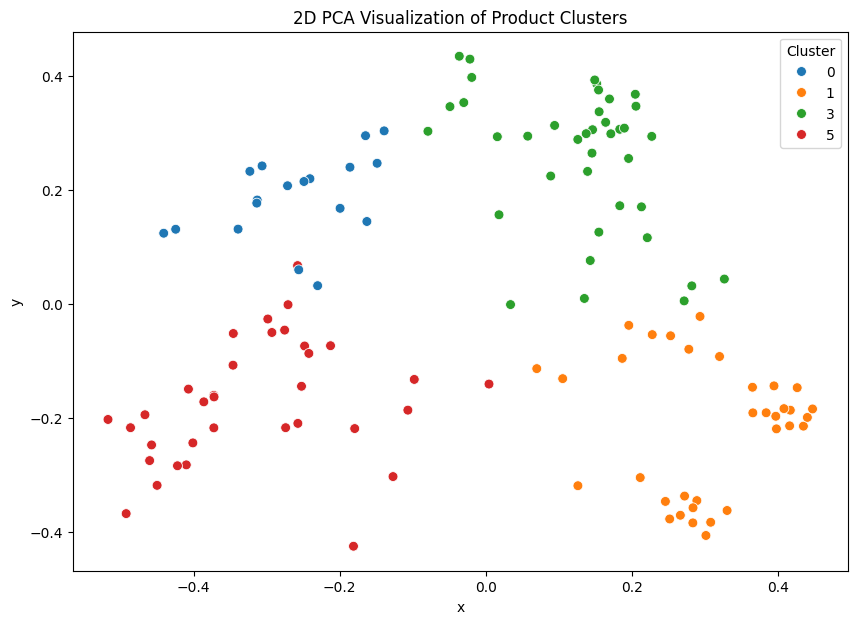

In [23]:
# Reduce from 50D → 2D for visualization
pca_2d = PCA(n_components=2, random_state=42)
embedding_2d = pca_2d.fit_transform(embeddings)

# Add coordinates to DataFrame
df_unique['x'] = embedding_2d[:, 0]
df_unique['y'] = embedding_2d[:, 1]

# Plot clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_unique, x='x', y='y', hue='cluster_label', palette='tab10', s=50)
plt.title("2D PCA Visualization of Product Clusters")
plt.legend(title='Cluster')
plt.show()

In [24]:
# Create a final DataFrame with the required columns
df_final = df_unique[['name', 'cluster_label', 'review', 'reviews.rating']].copy()
print(df_final.info())
print(df_final.head())

<class 'pandas.core.frame.DataFrame'>
Index: 125 entries, 0 to 59039
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            125 non-null    object 
 1   cluster_label   125 non-null    int32  
 2   review          125 non-null    object 
 3   reviews.rating  125 non-null    float64
dtypes: float64(1), int32(1), object(2)
memory usage: 4.4+ KB
None
                                                  name  cluster_label  \
0    All-New Kindle Oasis E-reader - 7 High-Resolut...              3   
4    All-New Kindle Oasis E-reader - 7 High-Resolut...              3   
26   Amazon Fire TV with 4K Ultra HD and Alexa Voic...              5   
30                  Echo (White),,,\r\nEcho (White),,,              5   
402  Amazon Kindle Paperwhite - eBook reader - 4 GB...              3   

                                                review  reviews.rating  
0    Great device for reading. Definately pricey..

We merged all reviews (every row from the original data), but with the appropriate cluster name added based on their associated product.

In [25]:
cluster_map = df_unique[['name', 'cluster_name']]

df_full_clustered = df.merge(cluster_map, on='name', how='left')

final_view = df_full_clustered[['name', 'cluster_name', 'review', 'reviews.rating', 'sentiment']]



In [26]:
# Save to CSV
final_view.to_csv("full_reviews_with_clusters.csv", index=False)